In [1]:
import os
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt

from microsim.population import NHANESDirectSamplePopulation
from microsim.risk_factor import DynamicRiskFactorsType, StaticRiskFactorsType
from collections import Counter

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

### Validation of baseline simulated population

#### 2007-2009 NHANES

In [2]:
%%time
popSize = 100000
pop = NHANESDirectSamplePopulation(popSize, 2007)

CPU times: user 38.4 s, sys: 248 ms, total: 38.6 s
Wall time: 38.7 s


In [3]:
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    print(f"{rf.value:>50} {np.mean(rfList):> 6.1f}")
    
for i,rf in enumerate(StaticRiskFactorsType):
    print(f"{rf:>50}")
    rfList = list(map( lambda x: getattr(x, "_"+rf.value), pop._people))
    rfValueCounts = Counter(rfList)
    for key in rfValueCounts.keys():
        print(f"{key:>50} {rfValueCounts[key]/popSize: 6.2f}")

                                               age   45.7
                                               sbp  121.3
                                               dbp   70.7
                                               a1c    5.1
                                               hdl   52.1
                                               ldl  118.0
                                              trig  139.1
                                           totChol  196.1
                                               bmi   27.9
                               anyPhysicalActivity    0.8
                                              afib    0.0
                                             waist   97.1
                                    alcoholPerWeek    2.2
                                        creatinine    0.2
                                               pvd    0.0
              StaticRiskFactorsType.RACE_ETHNICITY
                                                 3   0.69
                     

#### 2013, hypertension

In [4]:
%%time
popSize = 100000
pop = NHANESDirectSamplePopulation(popSize, 2013, filter=lambda x: x._antiHypertensiveCount[0]>0)

CPU times: user 37.7 s, sys: 228 ms, total: 38 s
Wall time: 38 s


In [5]:
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    print(f"{rf.value:>50} {np.mean(rfList):> 6.1f}")
    
for i,rf in enumerate(StaticRiskFactorsType):
    print(f"{rf.value:>50}")
    rfList = list(map( lambda x: getattr(x, "_"+rf.value), pop._people))
    rfValueCounts = Counter(rfList)
    for key in rfValueCounts.keys():
        print(f"{key:>50} {rfValueCounts[key]/popSize: 6.2f}")

                                               age   60.1
                                               sbp  128.4
                                               dbp   69.7
                                               a1c    5.6
                                               hdl   51.4
                                               ldl  108.1
                                              trig  134.7
                                           totChol  186.0
                                               bmi   30.9
                               anyPhysicalActivity    0.6
                                              afib    0.1
                                             waist  106.3
                                    alcoholPerWeek    2.0
                                        creatinine    0.4
                                               pvd    0.1
                                     raceEthnicity
                                                 3   0.22
                     

### Validation of vascular risk factors over time

In [6]:
#from microsim.sim_settings import simSettings
#pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
#simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel
#seedSequence = np.random.SeedSequence()
#rngStream = np.random.default_rng(seed=seedSequence)
#from microsim.bp_treatment_strategies import AddASingleBPMedTreatmentStrategy

In [7]:
%%time
popSize = 100000
nYears = 18
pop = NHANESDirectSamplePopulation(popSize, 1999)

CPU times: user 37.6 s, sys: 127 ms, total: 37.7 s
Wall time: 37.7 s


In [8]:
%%time
#1m 47 s
pop.advance_parallel(nYears, None, 5)

CPU times: user 37.2 s, sys: 3.45 s, total: 40.6 s
Wall time: 7min 45s


In [9]:
#pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
#controlPop = NHANESDirectSamplePopulation(popSize, 1999, rng=rngStream)
#treatmentPop = NHANESDirectSamplePopulation(popSize, 1999, rng=rngStream)
#treatmentPop.set_bp_treatment_strategy(AddASingleBPMedTreatmentStrategy())

In [10]:
%%time
#40min
#alive, dead = pop.advance_vectorized(18,rng=rngStream) #5m 9s - no recalibration
#aliveC, deadC = controlPop.advance_vectorized(5,rng=rngStream)
#aliveT, deadT = treatmentPop.advance_vectorized(5,rng=rngStream)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 1.67 µs


In [11]:
#controlRisk = sum(list(map(lambda x: x.has_stroke_during_simulation(), controlPop._people)))/controlPop.n
#treatmentRisk = sum(list(map(lambda x: x.has_stroke_during_simulation(), treatmentPop._people)))/treatmentPop.n
#0.87 
#print(treatmentRisk/controlRisk)
#controlRisk = sum(list(map(lambda x: x.has_mi_during_simulation(), controlPop._people)))/controlPop.n
#treatmentRisk = sum(list(map(lambda x: x.has_mi_during_simulation(), treatmentPop._people)))/treatmentPop.n
#0.87 
#print(treatmentRisk/controlRisk)

In [12]:
from microsim.population import microsimToNhanes

nhanesPop = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
nhanesPop = nhanesPop[~(nhanesPop["timeInUS"]<4)]
nhanesPop = nhanesPop[nhanesPop["year"]==2017]
nhanesPop = nhanesPop[nhanesPop["age"]>=36]

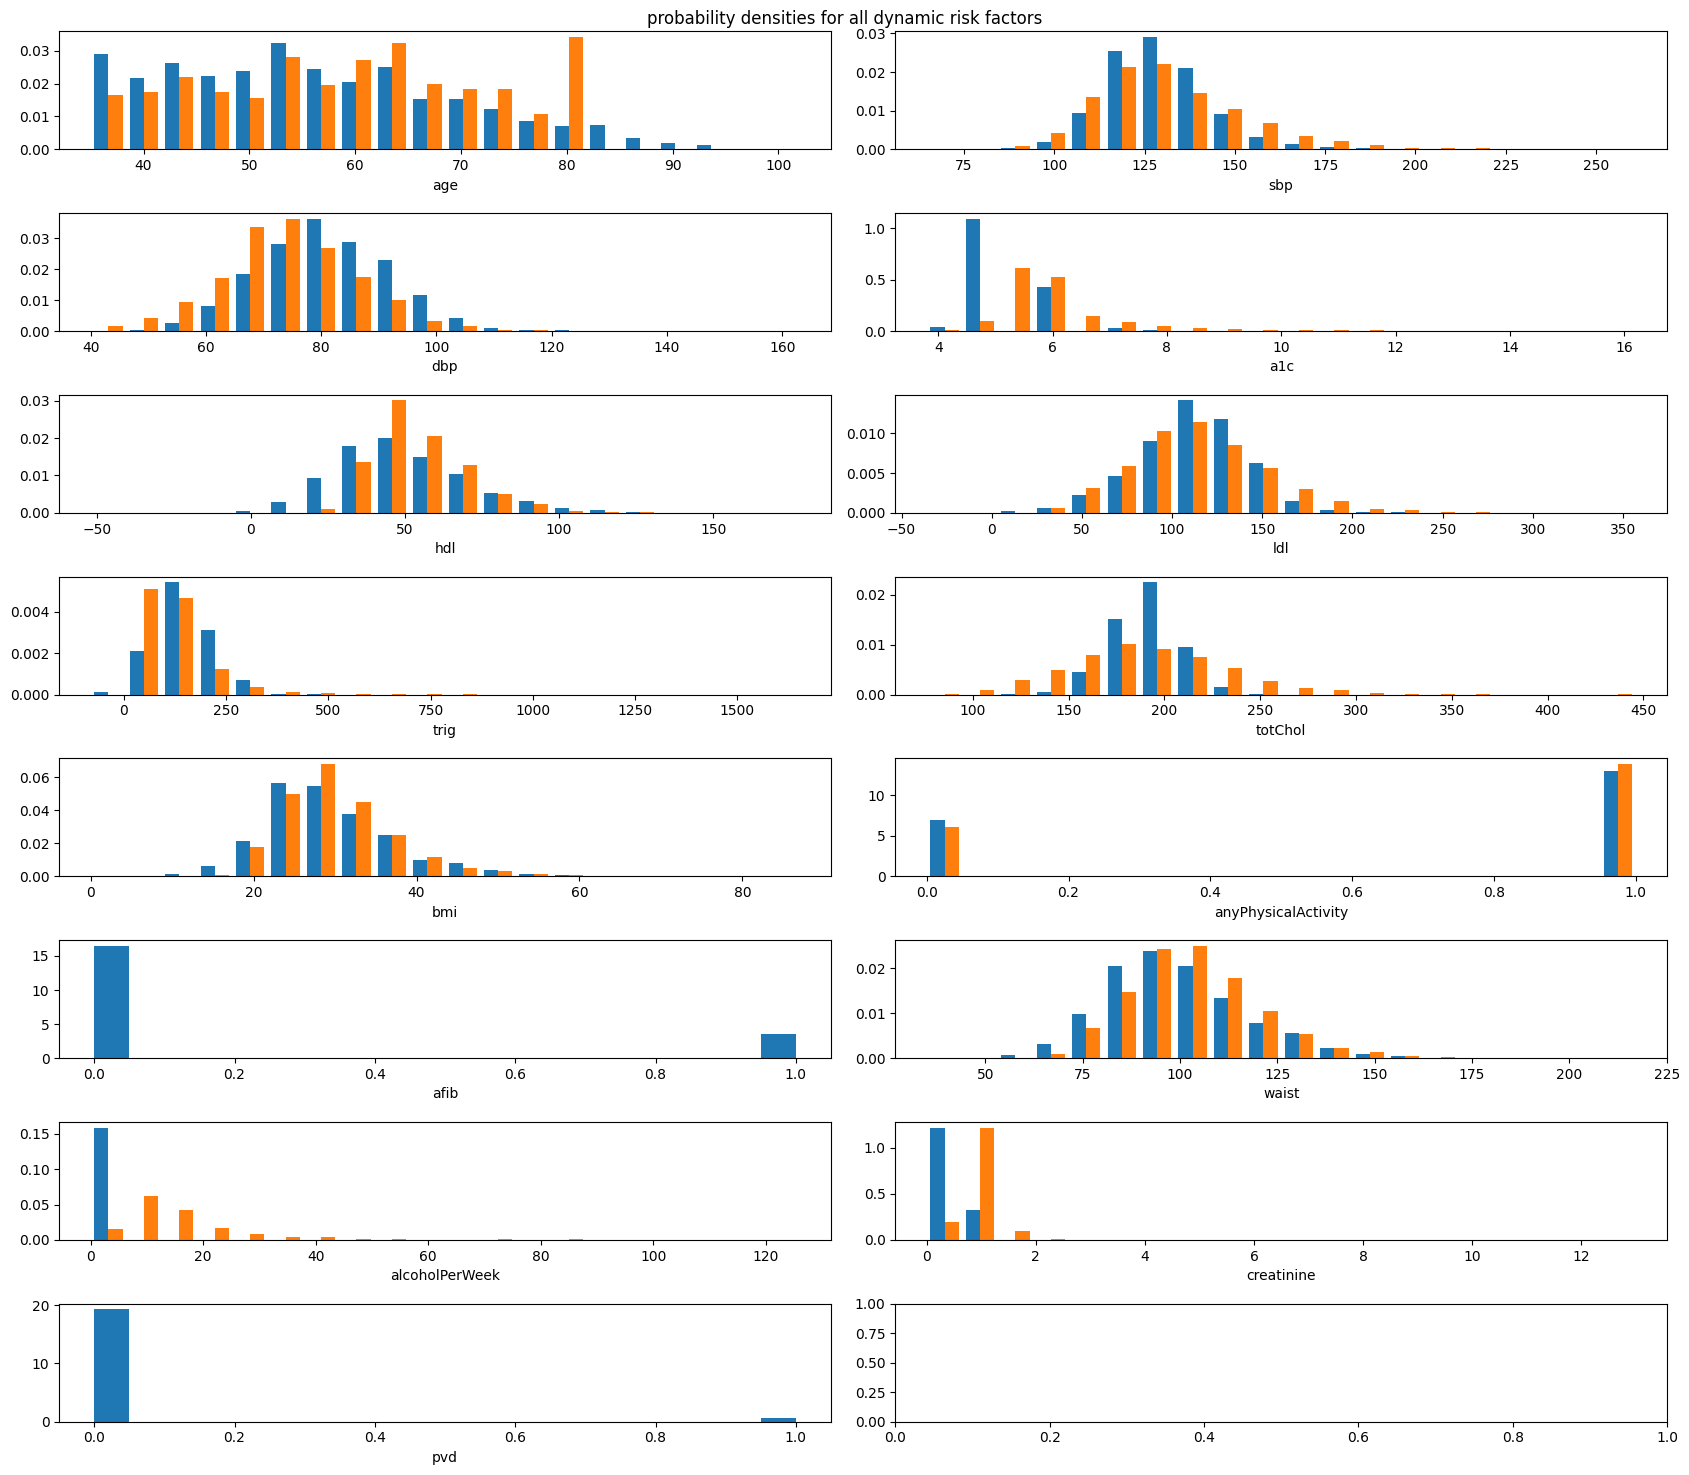

In [13]:
nRows = round(len(DynamicRiskFactorsType)/2)
fig, ax = plt.subplots(nRows, 2, figsize=(17,15))
row=-1
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if i%2==0:
        row += 1
        col = 0
    else:
        col = 1
    if rf.value in microsimToNhanes.keys():
        ax[row,col].hist([rfList, nhanesPop[microsimToNhanes[rf.value]]], bins=20, density=True)
    else:
        ax[row,col].hist(rfList, bins=20, density=True)
    ax[row,col].set_xlabel(rf.value)
    #ax[row,col].set_ylabel("probability density")
plt.suptitle("probability densities for all dynamic risk factors")
#plt.subplots_adjust(wspace=0.5, hspace=0.7)
plt.tight_layout()
plt.show()

In [14]:
space = " "
print("                       sim mean   nha mean    sim sd     nha sd")
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if rf.value in microsimToNhanes.keys():
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {np.mean(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}" + 
             f"{np.std(rfList): 10.2f} {np.std(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}")
    else:
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {space:>9} {np.std(rfList): 10.2f}")

                       sim mean   nha mean    sim sd     nha sd
                 age      55.97      59.43     13.58      13.07
                 sbp     129.62     131.21     14.99      20.65
                 dbp      81.40      73.77     11.60      11.94
                 a1c       5.31       6.05      0.61       1.20
                 hdl      49.22      53.65     21.36      16.13
                 ldl     112.18     114.03     30.36      37.59
                trig     153.00     121.37     69.89      91.21
             totChol     191.35     190.69     17.91      42.14
                 bmi      29.68      30.12      8.28       7.15
 anyPhysicalActivity       0.65       0.69      0.48       0.46
                afib       0.18                 0.38
               waist      99.38     102.95     18.43      16.40
      alcoholPerWeek       0.99      14.44      0.38      14.17
          creatinine       0.23       0.94      0.57       0.49
                 pvd       0.04                 0.1

### Validation of CV event incidence and mortality

In [15]:
from microsim.outcome import OutcomeType
outcomes = [OutcomeType.MI, OutcomeType.STROKE, OutcomeType.DEATH, 
            OutcomeType.CARDIOVASCULAR, OutcomeType.NONCARDIOVASCULAR, OutcomeType.DEMENTIA]
standardizedRates = list(map(lambda x: pop.calculate_mean_age_sex_standardized_incidence(x, 2016), outcomes))
standardizedRatesBlack = list(map(
                           lambda x: pop.calculate_mean_age_sex_standardized_incidence(x,2016, lambda y: y._black), 
                           outcomes))
print("standardized rates (per 100,000)    all        black   ")
for i in range(len(outcomes)):
    print(f"{outcomes[i].value:>30} {standardizedRates[i]:> 10.1f} {standardizedRatesBlack[i]:> 10.1f}") 

standardized rates (per 100,000)    all        black   
                            mi      239.0      210.1
                        stroke      155.5      277.2
                         death      859.0      956.4
                            cv      394.5      487.3
                         noncv      805.0      890.0
                      dementia      271.8      577.8


### Validation of dementia incidence

In [16]:
dementiaIncidentRate = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

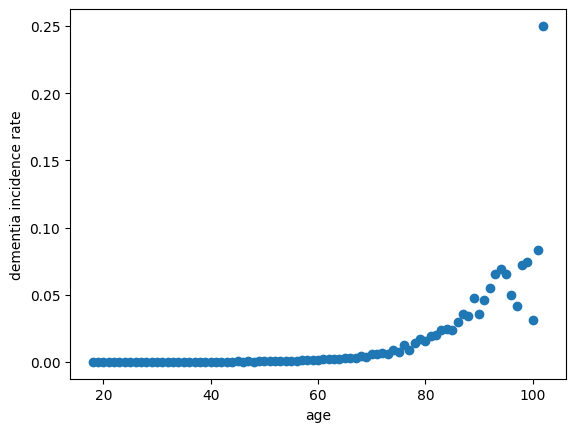

In [17]:
plt.scatter(dementiaIncidentRate.keys(), dementiaIncidentRate.values())
plt.xlabel("age")
plt.ylabel("dementia incidence rate")
plt.show()

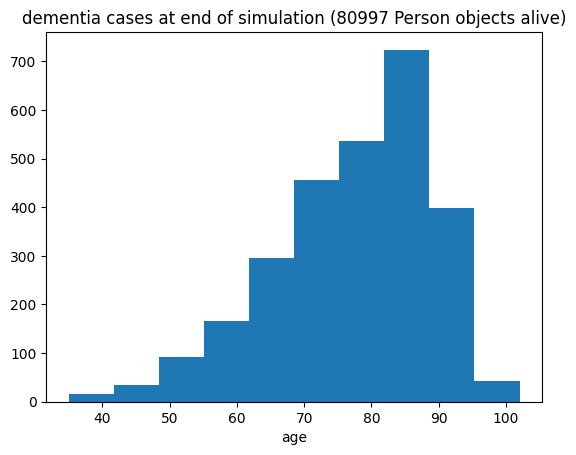

In [18]:
ageDementia = list(map(lambda y: (y._age[-1], len(y._outcomes[OutcomeType.DEMENTIA])>0), 
              list(filter(lambda x: x.is_alive, pop._people))))
nAlive = len(ageDementia)
ageDementia = list(filter(lambda x: x[1]==True, ageDementia))
ageDementia = [int(x[0]) for x in ageDementia]
plt.hist(ageDementia)
plt.xlabel("age")
plt.title(f"dementia cases at end of simulation ({nAlive} Person objects alive)")
plt.show()

### Validation of treatment effects

In [ ]:
%%time
#35min for 200k
from microsim.treatment_strategy_repository import TreatmentStrategyRepository
from microsim.bp_treatment_strategies import AddASingleBPMedTreatmentStrategy
from microsim.treatment import TreatmentStrategiesType
from microsim.outcome import OutcomeType

popSize = 200000
treatmentPop = NHANESDirectSamplePopulation(popSize, 1999)
controlPop = NHANESDirectSamplePopulation(popSize, 1999)
nYears=5
treatmentStrategies = TreatmentStrategyRepository()
treatmentStrategies._repository[TreatmentStrategiesType.BP.value] = AddASingleBPMedTreatmentStrategy()
treatmentPop.advance(nYears, treatmentStrategies = treatmentStrategies)
controlPop.advance(nYears)

In [ ]:
controlRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.STROKE), 
                           controlPop._people)))/controlPop._n
treatmentRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.STROKE), 
                             treatmentPop._people)))/treatmentPop._n
#0.93
controlRisk, treatmentRisk, treatmentRisk/controlRisk

In [ ]:
controlRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.MI), 
                           controlPop._people)))/controlPop._n
treatmentRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.MI), 
                             treatmentPop._people)))/treatmentPop._n
#0.90
controlRisk, treatmentRisk, treatmentRisk/controlRisk